<h1>Reconocimiento facial con PCA y SVM<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

En este notebook vamos a intentar resolver el problema de reconocimiento facial, usando un dataset con caras de personajes conocidos.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Importamos el dataset, incluido en sklearn:

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60, data_home='data')
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Pintamos algunas de esas caras para saber con qué tipo de datos estamos trabajando:

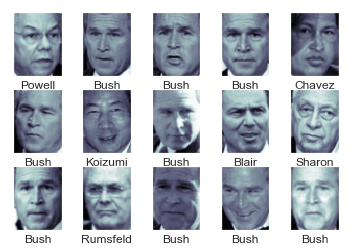

In [3]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]].split()[-1])

Cada imagen tiene un tamaño de 62x47, lo que supone unos 3000 pixeles. Podríamos usar cada pixel como una característica, pero merece la pena aplicar reducción de la dimensionalidad en el preprocesado de los datos. En este caso usaremos PCA normalizado para quedarnos con 150 componentes.

Usaremos SVC para el modelo. Aplicaremos ambas cosas con una tubería. Además dividiremos nuestro conjunto de datos en subconjuntos de entrenamiento y test, para poder validar el modelo:

In [4]:
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Usaremos una rejilla para aplicar validación cruzada. El motivo es ajustar `C` (parámetro que controla la rigidez de los márgenes) y `gamma` (tamaño del kernel) para determinar el modelo óptimo:

In [5]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=3)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 21.9 s
{'svc__C': 10, 'svc__gamma': 0.001}


Con esto ya podemos predecir las etiquetas para los datos de test:

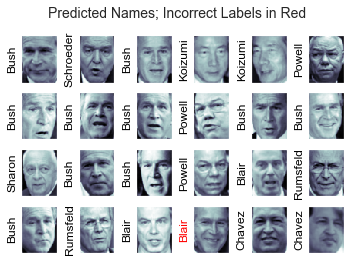

In [6]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

# Dibujamos las imágenes de test con la etiqueta que ha predecido el modelo
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Como podemos ver, nuestro estimador se ha equivocado sólo en una de las 24 caras comprobadas.

Podemos obtener una información más completa del rendimiento del estimado usando `classification_report` para listar estadísticas por etiqueta:

In [7]:
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



También podemos pintar la matriz de confusión:

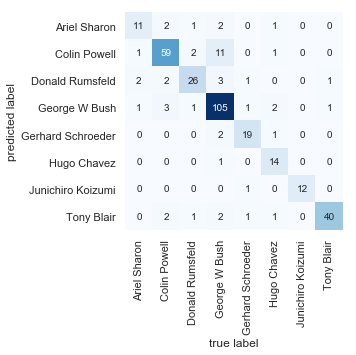

In [8]:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=faces.target_names,
            yticklabels=faces.target_names, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Para un problema de reconocimiento facial del mundo real, donde las fotos no vienen preparadas, necesitaríamos un algoritmo más sofisticado para encontrar las caras y extraer las características. Podemos usar por ejemplo [OpenCV](http://opencv.org/) para tener al alcance de la mano implementaciones ya entrenadas de herramientas para extracción de características de imágenes en general y de caras en particular.